In [1]:
import re
import os
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Select Patients Treated with vasodilators & vasoconstrictors from MIMIC II Clinical Database

In [2]:
POE_MED = glob.glob("./data/00/*/POE_MED*")
POE_ORDER = glob.glob("./data/00/*/POE_ORDER*")
MEDEVENTS = glob.glob("./data/00/*/MEDEVENTS*")

### Function to read and merge clinical data CSVs

In [3]:
def read_csvs(file_list):
    data = []
    header_saved = False
    for file in file_list:
        # skip empty files
        if os.stat(file).st_size != 0:
            with open(file, 'r') as f:
                reader = csv.reader(f)
                header = ['DIR_NAME'] + next(reader, None)
                # keep only the first header
                if not header_saved:
                    data.append(header)
                    header_saved = True
                for line in reader:
                    fname = file.split('/')[3]
                    data.append([fname] + line)
    return data

In [4]:
drugs = read_csvs(POE_MED)
medev = read_csvs(MEDEVENTS)
orders = read_csvs(POE_ORDER)

df_orders = pd.DataFrame(orders[1:], columns=orders[0])
df_medev = pd.DataFrame(medev[1:], columns=medev[0])
df_drugs = pd.DataFrame(drugs[1:], columns=drugs[0])

### Filter by drugs of interest

In [5]:
vasodilators = '|'.join(['nitroglycerin', 'nitroprussid'])
vasoconstrictors = '|'.join(['neosynephrine', 'epinephrine', 'neosyneprine', 'epinephrine drip', 'dobutamine', 'dobutamine'])

vasoconstrictor_index = df_drugs.DRUG_NAME_GENERIC.str.contains(vasoconstrictors, case=False)
vasodilator_index = df_drugs.DRUG_NAME_GENERIC.str.contains(vasodilators, case=False)

df_vasoconstrictor = df_drugs[vasoconstrictor_index]
df_vasodilator = df_drugs[vasodilator_index]

### Determine time of drug administration

In [6]:
# todo

# 2. Merge clinical data with MIMIC II Waveform Matched Subset

### Download waveform record names that have been matched with clinical records

In [7]:
# import urllib.request
# 
# RECORDS_waveforms = 'https://www.physionet.org/physiobank/database/mimic2wdb/matched/RECORDS-waveforms'
# 
# with urllib.request.urlopen(RECORDS_waveforms) as response:
#    html = response.readlines()
# 
# with open('RECORDS_waveforms.txt', 'w') as f:
#     for line in html:
#         f.write(str(line)[2:-3] + '\n')

In [8]:
RECORDS_waveforms = open('./data/RECORDS_waveforms.txt', 'r').readlines()
matched_waveform_codes = [x.split('/')[0][1:] for x in RECORDS_waveforms]

### Filter patients that have waveform data available that also had a vasoconstrictor/vasodilator

In [9]:
df_vasoconstrictor[df_vasoconstrictor.DIR_NAME.isin(matched_waveform_codes)]

,DIR_NAME,POE_ID,DRUG_TYPE,DRUG_NAME,DRUG_NAME_GENERIC,PROD_STRENGTH,FORM_RX,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,DOSE_VAL_DISP,DOSE_UNIT_DISP,DOSE_RANGE_OVERRIDE
11745,00177,1080930,MAIN,Lidocaine 0.5%/Epinephrine,Lidocaine 0.5%/Epinephrine,50ML VIAL,,1,ml,1,VIAL,,,
25285,00402,4696794,MAIN,Lidocaine 1%/Epinephrine 1:100000,Lidocaine 1%/Epinephrine 1:100000,20mL Vial,,5,ml,0.25,VIAL,,,


In [10]:
df_vasodilator[df_vasodilator.DIR_NAME.isin(matched_waveform_codes)]

,DIR_NAME,POE_ID,DRUG_TYPE,DRUG_NAME,DRUG_NAME_GENERIC,PROD_STRENGTH,FORM_RX,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,DOSE_VAL_DISP,DOSE_UNIT_DISP,DOSE_RANGE_OVERRIDE
11692,00177,1011023,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.4MG SL TAB,,0.4,mg,1,TAB,,,
11693,00177,1011024,MAIN,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,30g Tube,,1,in,0.01,TUBE,,,
20836,00328,93149,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,TAB,0.3,mg,1,TAB,.30000001192092896,mg,
23440,00368,663618,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,,0.3,mg,1,TAB,,,
27612,00427,345299,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,TAB,0.3,mg,1,TAB,.30000001,mg,
31967,00491,429759,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,TAB,0.3,mg,1,TAB,.30000001,mg,
42230,00682,1647112,MAIN,Nitroglycerin Oint. 2%,Nitroglycerin Oint. 2%,1 gm Packet,,1,in,1,PKT,,,
43537,00703,534862,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,TAB,0.3,mg,1,TAB,.30000001,mg,
50704,00801,4043858,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3mg SL Tablet Bottle,,0.3,mg,1,TAB,,,
55505,00894,841595,MAIN,Nitroglycerin SL,Nitroglycerin SL,0.3MG SL TAB,,0.3,mg,1,TAB,,,


### Import waveforms from Matlab data format

In [11]:
import numpy as np
from scipy.io import loadmat

df_s00177_mat = loadmat('./data/3555290_0001m.mat')['val'].T

df_s00177_mat

array([[124, 127, 113],
       [124, 127, 113],
       [125, 127, 112],
       ..., 
       [128, 127,  80],
       [128, 128,  80],
       [128, 129,  79]], dtype=uint8)

### Import waveforms from CSV

In [12]:
df_s00177 = pd.read_csv('./data/s00177.csv', names=['time', 'II', 'MCL1', 'ABP'], low_memory=False)

In [13]:
df_s00177.head()

,time,II,MCL1,ABP
0,'[12:35:33.833]',-0.053,-0.062,68.0
1,'[12:35:33.841]',-0.053,-0.062,68.0
2,'[12:35:33.849]',-0.039,-0.062,67.2
3,'[12:35:33.857]',-0.039,-0.062,67.2
4,'[12:35:33.865]',-0.053,-0.062,66.4


In [14]:
df_s00177.shape

(4979781, 4)

In [15]:
df_s00177.index = pd.to_datetime(df_s00177.time, format="\'[%H:%M:%S.%f]\'")

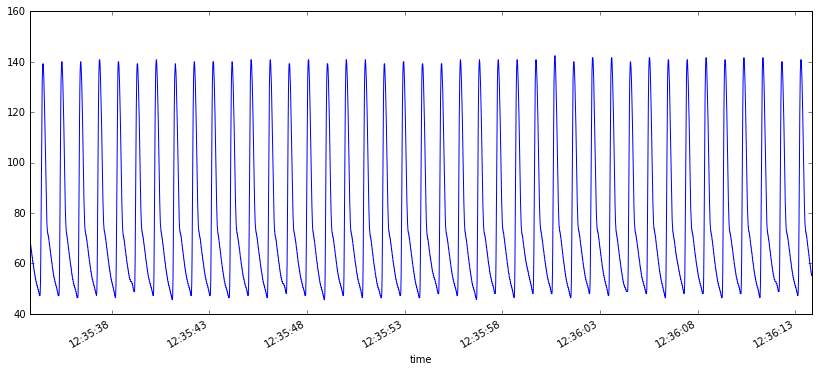

In [16]:
df_s00177.ABP[:5000].plot(figsize=(14,6))